### This is a basic implementation of MLP and SVM models with cross-validation and learning curve plotting.

In [1]:
# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting
from sklearn.model_selection import train_test_split, cross_validate, learning_curve  # For model evaluation
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.neural_network import MLPClassifier  # For Multi-Layer Perceptron classifier
from sklearn.svm import SVC  # For Support Vector Machine classifier
from sklearn.pipeline import make_pipeline  # For creating a pipeline of transformations
from sklearn.metrics import accuracy_score, log_loss, f1_score  # For model evaluation metrics

# Load and preprocess the data 
data = pd.read_csv('final_dataset.csv')  # Read the CSV file
X = data.iloc[:, :-1].values / 255.0  # Extract features and normalize to [0, 1] range
y = data.iloc[:, -1].values  # Extract target variable

# Split the data into training and test sets
# use stratification (stratify=y) to ensure that the class distribution is maintained in both sets, which is crucial for imbalanced datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create models
# use make_pipeline to create a pipeline that first scales the data and then applies the classifier
# Note : ConvegenceWarning για το MLP model , αυτό συμβαίνει όταν το μοντέλο δεν συγκλίνει στην ελάχιστη τιμή της συνάρτησης κόστους μετά από έναν αριθμό μέγιστων επαναλήψεων., 
# οπότε αυξάνω max_iter στα 2000
mlp = make_pipeline(StandardScaler(), MLPClassifier(random_state=42, max_iter=2000))  # MLP with standardization
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42, probability=True))  # SVM with standardization

# Define scoring metrics for cross-validation
scoring = ['accuracy', 'neg_log_loss', 'f1_weighted']

# Function to perform cross-validation
# cv is about the number of folds to use for cross-validation. A cv value of 5 means that the dataset is split into 5 equal parts, and each part is used as a validation set once while the other parts are used for training.
def perform_cv(model, X, y, scoring):
    scores = cross_validate(model, X, y, scoring=scoring, cv=5, return_estimator=True)
    return scores

# Perform cross-validation for both models
mlp_scores = perform_cv(mlp, X_train, y_train, scoring)
svm_scores = perform_cv(svm, X_train, y_train, scoring)

# Function to print cross-validation results (accuracy, log-loss, and F1-score) for a given model 
def print_cv_results(model_name, scores):
    print(f"{model_name} Cross-Validation Results:")
    # υπολογίζει τη μέση ακρίβεια από όλες τις επαναλήψεις της crorss-validation folds , και εμφανίζει επίσης ένα διάστημα εμπιστοσύνης 95%, το οποίο μας δείχνει πόσο 
    # πιθανό είναι η πραγματική ακρίβεια να βρίσκεται εντός αυτού του εύρους.
    print(f"Accuracy: {scores['test_accuracy'].mean():.4f} (+/- {scores['test_accuracy'].std() * 2:.4f})")
    # long-loss : μετρά πόσο "εκτός" είναι οι προβλέψεις μας από τις πραγματικές τιμές. Όσο χαμηλότερη είναι η τιμή log-loss, τόσο καλύτερη είναι η απόδοση του μοντέλου. 
    # Και πάλι, ο κώδικας υπολογίζει τον μέσο όρο και το διάστημα εμπιστοσύνης 95% για να μας δώσει μια πιο ολοκληρωμένη εικόνα.
    print(f"Log-loss: {-scores['test_neg_log_loss'].mean():.4f} (+/- {scores['test_neg_log_loss'].std() * 2:.4f})")
    #F1-score: είναι ένας συνδυασμός της precision (πόσο ακριβείς είναι οι θετικές προβλέψεις μας) και της recall (πόσες από τις πραγματικές θετικές περιπτώσεις εντοπίσαμε). 
    # Το F1-score είναι ιδιαίτερα χρήσιμο όταν έχουμε ανισορροπημένα σύνολα δεδομένων.  Ο κώδικας υπολογίζει τον "weighted" F1-score, ο οποίος λαμβάνει υπόψη τη συχνότητα κάθε 
    # κατηγορίας στις προβλέψεις. Και πάλι, υπολογίζονται ο μέσος όρος και το διάστημα εμπιστοσύνης.
    print(f"F1-score: {scores['test_f1_weighted'].mean():.4f} (+/- {scores['test_f1_weighted'].std() * 2:.4f})")
    print()

# Print cross-validation results for both models (accuracy, log-loss, and F1-score) 
print_cv_results("MLP", mlp_scores)
print_cv_results("SVM", svm_scores)

# Choose the best model based on cross-validation accuracy scores and print the result 
if mlp_scores['test_accuracy'].mean() > svm_scores['test_accuracy'].mean():
    best_model = mlp
    print("MLP chosen as the best model.")
else:
    best_model = svm
    print("SVM chosen as the best model.")

# Retrain the chosen model on the entire training set and evaluate on the test set to get final results 
best_model.fit(X_train, y_train)

# Evaluate on the test set using the best model chosen from cross-validation results and print the results on the test set (accuracy, log-loss, and F1-score) 
y_pred = best_model.predict(X_test)  # Make predictions
y_pred_proba = best_model.predict_proba(X_test)  # Get prediction probabilities

# Print test set results (accuracy, log-loss, and F1-score) 
print("\nTest Set Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Log-loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Function to plot learning curves for a given model 
def plot_learning_curve(model, X, y, title):
    # δημιουργώ έναν πίνακα με 5 ισαπέχοντα σημεία από 0.1 έως 1.0,
    train_sizes = np.linspace(0.1, 1.0, 5)  
    # υπολογίζω την καμπύλη μάθησης χρησιμοποιώντας την συνάρτηση learning_curve του scikit-learn. 
    # υπολογίζει τα σκόρ εκπαίδευσης και ελέγχου για κάθε μέγεθος εκπαίδευσης και επιστρέφει τα αποτελέσματα σε έναν πίνακα.
    # χρησιμοποιεί 5 cross-validation folds και την ακρίβεια ως μετρική αξιολόγησης.
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=train_sizes, scoring='accuracy'
    )
    
    # Υπολογίζει τον μέσο όρο και την τυπική απόκλιση των σκορ εκπαίδευσης και ελέγχου για κάθε μέγεθος συνόλου εκπαίδευσης.
    # training scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    # test scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Δημιουργία νέου γράφηματος
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.grid()
    
    # Σχεδιάζει τις ζώνες σφάλματος (± 1 τυπική απόκλιση) για τα σκορ εκπαίδευσης (κόκκινο) και ελέγχου (πράσινο).
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Σχεδιάζει τις καμπύλες μάθησης για τα σκορ εκπαίδευσης και ελέγχου.
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

# Plot learning curves for both models
plot_learning_curve(mlp, X, y, "Learning Curve for MLP")
plot_learning_curve(svm, X, y, "Learning Curve for SVM")
plt.show()  # Display the plots


KeyboardInterrupt: 

## Important Notes 

- Normalization 255.0 : 

Υπάρχουν αρκετοί λόγοι γιατί χρησιμοποιείτεαι κανονικοποιήση . Από τους κυριότερους είναι ότι χρησιμοποιούμε MLP μοντέλο που στο κομμάτι της Gradient Descent Optimization , τα νευρωνικά δίκτυα χρησιμοποιούν την κάθοδο κλίσης για να μάθουν.  Όταν τα χαρακτηριστικά έχουν πολύ διαφορετικές κλίμακες, μπορεί να δημιουργηθεί μια "απότομη" επιφάνεια σφάλματος, καθιστώντας δυσκολότερη τη σύγκλιση του αλγορίθμου σε μια βέλτιστη λύση. Η κανονικοποίηση βοηθά στην εξομάλυνση της επιφάνειας σφάλματος, οδηγώντας σε ταχύτερη και σταθερότερη μάθηση.

Επίσης για το μοντέλο SVM που ανήκοει στους αλγορίθμους βασισμένοι στην απόσταση βασίζονται σε υπολογισμούς απόστασης. Εάν ένα χαρακτηριστικό έχει πολύ μεγαλύτερο εύρος, θα κυριαρχήσει στον υπολογισμό της απόστασης, διαστρεβλώνοντας τις πραγματικές σχέσεις μεταξύ των σημείων δεδομένων. Η κανονικοποίηση εξασφαλίζει ότι όλα τα χαρακτηριστικά συμβάλλουν εξίσου στους υπολογισμούς απόστασης.

Ο κύριος λόγος είναι να διασφαλιστεί ότι η κατεύθυνση του διανύσματος του δείγματος είναι πιο σημαντική από το μέγεθός του.

- - Υπολογίζεται από τον τύπο : Normalized Value = (Original Value - Minimum Value) / (Maximum Value - Minimum Value) , δηλαδή σαν παράδειγμα :για RGB1_R με τιμή 229.  
RGB1_R = (229 - 0) / (255 - 0) = 0.898

- StandardScale() : 

Η τυποποίηση μετατρέπει τα δεδομένα σας έτσι ώστε να έχουν μέση τιμή 0 και τυπική απόκλιση 1. Αυτό επιτυγχάνεται αφαιρώντας τον μέσο όρο του χαρακτηριστικού από κάθε τιμή και στη συνέχεια διαιρώντας με την τυπική απόκλιση.

- - Με μαθηματικό τύπο : X' = (X - μ) / σ , όπου X: Η αρχική τιμή του χαρακτηριστικού , μ: Ο μέσος όρος (mean) όλων των τιμών του χαρακτηριστικού , σ: Η τυπική απόκλιση (standard deviation) όλων των τιμών του χαρακτηριστικού και X': Η τυποποιημένη τιμή του χαρακτηριστικού.

- - Πώς λειτουργεί ο τύπος : 

Κεντράρισμα: Αφαιρώντας τον μέσο όρο (μ) από κάθε τιμή, μετατοπίζουμε όλες τις τιμές έτσι ώστε ο νέος μέσος όρος να είναι το 0. Αυτό σημαίνει ότι οι τιμές που ήταν μεγαλύτερες από τον μέσο όρο θα γίνουν θετικές, ενώ οι τιμές που ήταν μικρότερες από τον μέσο όρο θα γίνουν αρνητικές. 
Κλιμάκωση: Διαιρώντας με την τυπική απόκλιση (σ), αλλάζουμε την κλίμακα των τιμών έτσι ώστε η νέα τυπική απόκλιση να είναι 1. Αυτό σημαίνει ότι οι τιμές που ήταν πολύ μακριά από τον μέσο όρο θα "συμπιεστούν" προς το κέντρο, ενώ οι τιμές που ήταν κοντά στον μέσο όρο θα "απλωθούν" λίγο περισσότερο.

Είναι απαίτηση κάποιων αλγορίθμων όπως του SVM , καθώς υποθέτουν ότι τα δεδομένα εισόδου είναι τυποποιημένα. 

Όταν τα χαρακτηριστικά έχουν πολύ διαφορετικές κλίμακες, εκείνα με τις μεγαλύτερες τιμές μπορεί να κυριαρχήσουν στην εκπαίδευση του μοντέλου. Η κλιμάκωση βοηθά στην αποφυγή αυτού του προβλήματος. Η τυποποίηση εξασφαλίζει ότι όλα τα χαρακτηριστικά έχουν μέση τιμή 0 και τυπική απόκλιση 1, δίνοντάς τους έτσι ίση βαρύτητα κατά την εκπαίδευση του μοντέλου.
Αντίστοιχα είναι καλό για να μην η παρουσία ακραίων τιμών ποκαλέσει κάποιο πρόβλημα . 




### This version adds model fit analysis to detect overfitting or underfitting.

c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn

MLP Cross-Validation Results:
Accuracy: 0.4625 (+/- 0.0289)
Log-loss: 4.6808 (+/- 0.5360)
F1-score: 0.4398 (+/- 0.0315)

SVM Cross-Validation Results:
Accuracy: 0.2248 (+/- 0.0292)
Log-loss: 3.5097 (+/- 0.0353)
F1-score: 0.1885 (+/- 0.0340)



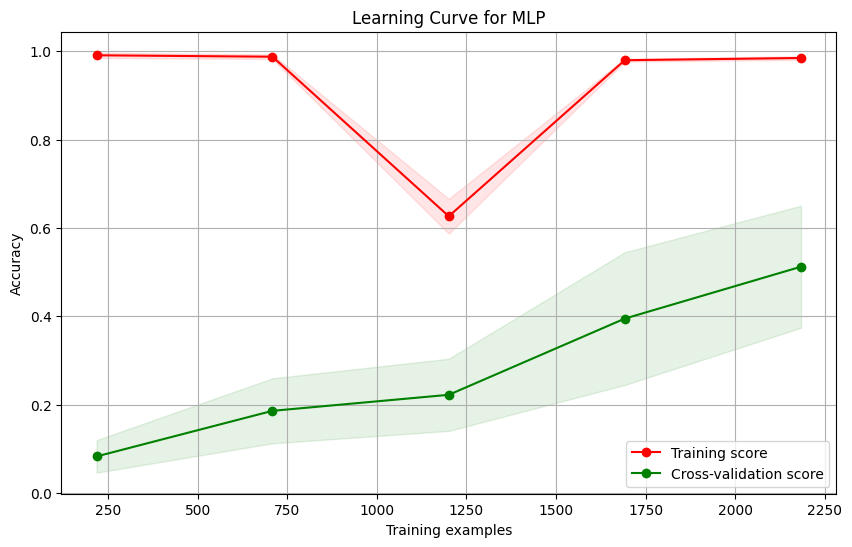


Analysis for MLP:
Final training score: 0.9847
Final validation score: 0.5121
The MLP shows signs of overfitting.
The training score is significantly higher than the validation score.
Consider using regularization techniques or reducing model complexity.


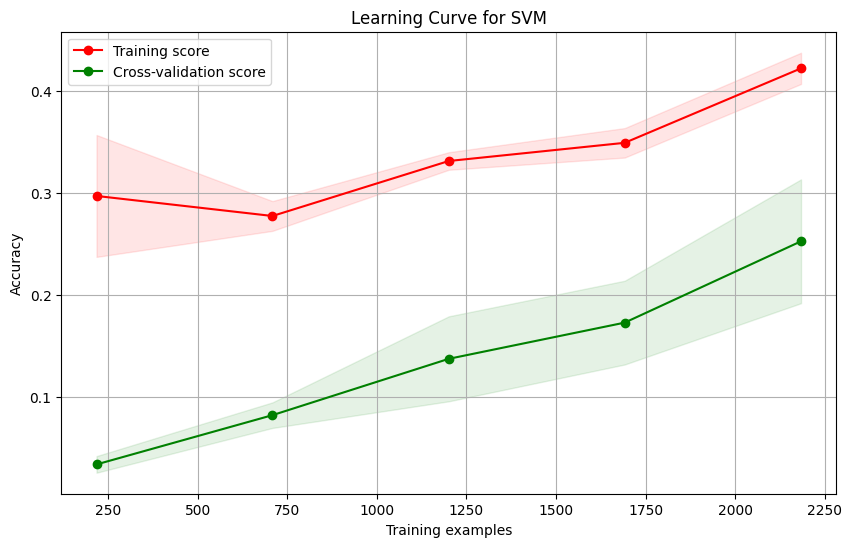


Analysis for SVM:
Final training score: 0.4225
Final validation score: 0.2527
The SVM shows signs of overfitting.
The training score is significantly higher than the validation score.
Consider using regularization techniques or reducing model complexity.

Model Selection:
MLP has higher accuracy, but shows signs of overfitting or underfitting.
Consider tuning the MLP model before selecting it.

No model selected due to overfitting/underfitting concerns.
Please tune the models and re-evaluate.


In [2]:
# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting
from sklearn.model_selection import train_test_split, cross_validate, learning_curve  # For model evaluation
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.neural_network import MLPClassifier  # For Multi-Layer Perceptron classifier
from sklearn.svm import SVC  # For Support Vector Machine classifier
from sklearn.pipeline import make_pipeline  # For creating a pipeline of transformations
from sklearn.metrics import accuracy_score, log_loss, f1_score  # For model evaluation metrics

# Load and preprocess the data 
data = pd.read_csv('final_dataset.csv')  # Read the CSV file
X = data.iloc[:, :-1].values / 255.0  # Extract features and normalize to [0, 1] range
y = data.iloc[:, -1].values  # Extract target variable

# Split the data into training and test sets
# use stratification (stratify=y) to ensure that the class distribution is maintained in both sets, which is crucial for imbalanced datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Function to perform cross-validation
def perform_cv(model, X, y, scoring):
    scores = cross_validate(model, X, y, scoring=scoring, cv=5, return_estimator=True)
    return scores

# Function to print cross-validation results (accuracy, log-loss, and F1-score) for a given model 
def print_cv_results(model_name, scores):
    print(f"{model_name} Cross-Validation Results:")
    # υπολογίζει τη μέση ακρίβεια από όλες τις επαναλήψεις της crorss-validation folds , και εμφανίζει επίσης ένα διάστημα εμπιστοσύνης 95%, το οποίο μας δείχνει πόσο 
    # πιθανό είναι η πραγματική ακρίβεια να βρίσκεται εντός αυτού του εύρους.
    print(f"Accuracy: {scores['test_accuracy'].mean():.4f} (+/- {scores['test_accuracy'].std() * 2:.4f})")
    # long-loss : μετρά πόσο "εκτός" είναι οι προβλέψεις μας από τις πραγματικές τιμές. Όσο χαμηλότερη είναι η τιμή log-loss, τόσο καλύτερη είναι η απόδοση του μοντέλου. 
    # Και πάλι, ο κώδικας υπολογίζει τον μέσο όρο και το διάστημα εμπιστοσύνης 95% για να μας δώσει μια πιο ολοκληρωμένη εικόνα.
    print(f"Log-loss: {-scores['test_neg_log_loss'].mean():.4f} (+/- {scores['test_neg_log_loss'].std() * 2:.4f})")
    #F1-score: είναι ένας συνδυασμός της precision (πόσο ακριβείς είναι οι θετικές προβλέψεις μας) και της recall (πόσες από τις πραγματικές θετικές περιπτώσεις εντοπίσαμε). 
    # Το F1-score είναι ιδιαίτερα χρήσιμο όταν έχουμε ανισορροπημένα σύνολα δεδομένων.  Ο κώδικας υπολογίζει τον "weighted" F1-score, ο οποίος λαμβάνει υπόψη τη συχνότητα κάθε 
    # κατηγορίας στις προβλέψεις. Και πάλι, υπολογίζονται ο μέσος όρος και το διάστημα εμπιστοσύνης.
    print(f"F1-score: {scores['test_f1_weighted'].mean():.4f} (+/- {scores['test_f1_weighted'].std() * 2:.4f})")
    print()
    
def plot_learning_curve(model, X, y, title):
    train_sizes = np.linspace(0.1, 1.0, 5)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=train_sizes, scoring='accuracy'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    
    return plt, train_scores_mean, test_scores_mean

def analyze_model_fit(train_scores, test_scores, model_name):
    print(f"\nAnalysis for {model_name}:")
    print(f"Final training score: {train_scores[-1]:.4f}")
    print(f"Final validation score: {test_scores[-1]:.4f}")
    
    if train_scores[-1] - test_scores[-1] > 0.1:
        print(f"The {model_name} shows signs of overfitting.")
        print("The training score is significantly higher than the validation score.")
        print("Consider using regularization techniques or reducing model complexity.")
    elif train_scores[-1] < 0.8 and test_scores[-1] < 0.8:
        print(f"The {model_name} shows signs of underfitting.")
        print("Both training and validation scores are low.")
        print("Consider increasing model complexity or training for more epochs.")
    else:
        print(f"The {model_name} seems to be fitting well.")
        print("The training and validation scores are close and reasonably high.")

# Create models
# use make_pipeline to create a pipeline that first scales the data and then applies the classifier
mlp = make_pipeline(StandardScaler(), MLPClassifier(random_state=42, max_iter=2000))  # MLP with standardization
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42, probability=True))  # SVM with standardization

# Define scoring metrics for cross-validation
scoring = ['accuracy', 'neg_log_loss', 'f1_weighted']

# Perform cross-validation for both models
mlp_scores = perform_cv(mlp, X_train, y_train, scoring)
svm_scores = perform_cv(svm, X_train, y_train, scoring)

# Print cross-validation results for both models (accuracy, log-loss, and F1-score) 
print_cv_results("MLP", mlp_scores)
print_cv_results("SVM", svm_scores)

# Plot and analyze learning curves for MLP
plt_mlp, train_scores_mlp, test_scores_mlp = plot_learning_curve(mlp, X, y, "Learning Curve for MLP")
plt_mlp.show()
analyze_model_fit(train_scores_mlp, test_scores_mlp, "MLP")

# Plot and analyze learning curves for SVM
plt_svm, train_scores_svm, test_scores_svm = plot_learning_curve(svm, X, y, "Learning Curve for SVM")
plt_svm.show()
analyze_model_fit(train_scores_svm, test_scores_svm, "SVM")

# Choose the best model based on cross-validation accuracy and fitting analysis
print("\nModel Selection:")
if mlp_scores['test_accuracy'].mean() > svm_scores['test_accuracy'].mean():
    if train_scores_mlp[-1] - test_scores_mlp[-1] <= 0.1 and test_scores_mlp[-1] >= 0.8:
        best_model = mlp
        print("MLP chosen as the best model.")
    else:
        print("MLP has higher accuracy, but shows signs of overfitting or underfitting.")
        print("Consider tuning the MLP model before selecting it.")
        best_model = None
else:
    if train_scores_svm[-1] - test_scores_svm[-1] <= 0.1 and test_scores_svm[-1] >= 0.8:
        best_model = svm
        print("SVM chosen as the best model.")
    else:
        print("SVM has higher accuracy, but shows signs of overfitting or underfitting.")
        print("Consider tuning the SVM model before selecting it.")
        best_model = None

# Only proceed with final evaluation if a best model was selected
if best_model is not None:
    # Retrain the chosen model on the entire training set
    best_model.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)

    print("\nTest Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Log-loss: {log_loss(y_test, y_pred_proba):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
else:
    print("\nNo model selected due to overfitting/underfitting concerns.")
    print("Please tune the models and re-evaluate.")

### This version introduces hyperparameter tuning using GridSearchCV.

c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Initial Cross-Validation Results:
MLP Cross-Validation Results:
Accuracy:
  Training: 0.9895 (+/- 0.0024)
  Validation: 0.4625 (+/- 0.0289)
Neg_log_loss:
  Training: -0.0998 (+/- 0.0113)
  Validation: -4.6808 (+/- 0.5360)
F1_weighted:
  Training: 0.9894 (+/- 0.0024)
  Validation: 0.4398 (+/- 0.0315)

SVM Cross-Validation Results:
Accuracy:
  Training: 0.4168 (+/- 0.0119)
  Validation: 0.2248 (+/- 0.0292)
Neg_log_loss:
  Training: -3.1475 (+/- 0.0225)
  Validation: -3.5097 (+/- 0.0353)
F1_weighted:
  Training: 0.3919 (+/- 0.0178)
  Validation: 0.1885 (+/- 0.0340)

MLP Grid Search:


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters: {'mlpclassifier__alpha': 0.0001, 'mlpclassifier__hidden_layer_sizes': (100,), 'mlpclassifier__learning_rate': 'constant'}
Best cross-validation score: 0.4625

SVM Grid Search:
Best parameters: {'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'poly'}
Best cross-validation score: 0.4597


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(



Cross-Validation Results after Hyperparameter Tuning:
Best MLP Cross-Validation Results:
Accuracy:
  Training: 0.9895 (+/- 0.0024)
  Validation: 0.4625 (+/- 0.0289)
Neg_log_loss:
  Training: -0.0998 (+/- 0.0113)
  Validation: -4.6808 (+/- 0.5360)
F1_weighted:
  Training: 0.9894 (+/- 0.0024)
  Validation: 0.4398 (+/- 0.0315)

Best SVM Cross-Validation Results:
Accuracy:
  Training: 0.9959 (+/- 0.0013)
  Validation: 0.4597 (+/- 0.0251)
Neg_log_loss:
  Training: -2.9683 (+/- 0.0204)
  Validation: -3.4589 (+/- 0.0603)
F1_weighted:
  Training: 0.9959 (+/- 0.0013)
  Validation: 0.4332 (+/- 0.0216)



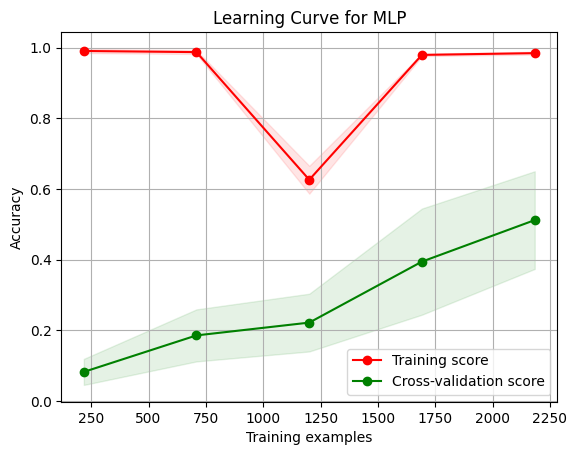

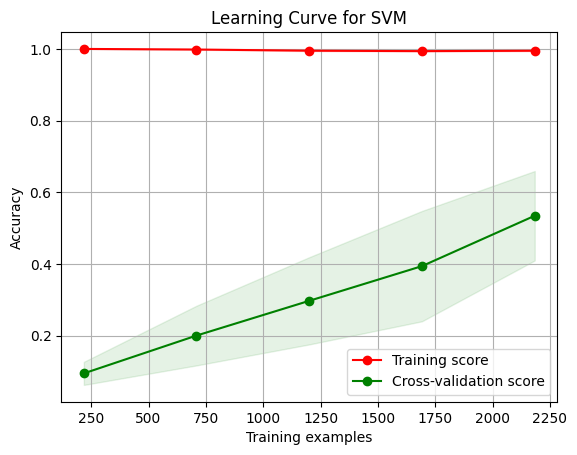

MLP chosen as the best model.

Test Set Results:
Accuracy: 0.4597
Log-loss: 4.7557
F1-score: 0.4400


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, log_loss, f1_score

# Load and preprocess the data
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create models with hyperparameters
mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(100,), alpha=0.0001)
)

svm = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', random_state=42, probability=True, C=1.0, gamma='scale')
)

# Define scoring metrics for cross-validation
scoring = ['accuracy', 'neg_log_loss', 'f1_weighted']

# Function to perform cross-validation
def perform_cv(model, X, y, scoring):
    scores = cross_validate(model, X, y, scoring=scoring, cv=5, return_train_score=True)
    return scores

# Function to print cross-validation results
def print_cv_results(model_name, scores):
    print(f"{model_name} Cross-Validation Results:")
    for metric in ['accuracy', 'neg_log_loss', 'f1_weighted']:
        train_scores = scores[f'train_{metric}']
        test_scores = scores[f'test_{metric}']
        print(f"{metric.capitalize()}:")
        print(f"  Training: {train_scores.mean():.4f} (+/- {train_scores.std() * 2:.4f})")
        print(f"  Validation: {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")
    print()

# Perform initial cross-validation for both models
mlp_scores = perform_cv(mlp, X_train, y_train, scoring)
svm_scores = perform_cv(svm, X_train, y_train, scoring)

# Print initial cross-validation results for both models
print("Initial Cross-Validation Results:")
print_cv_results("MLP", mlp_scores)
print_cv_results("SVM", svm_scores)

# Function to perform grid search for hyperparameter tuning
def perform_grid_search(model, param_grid, X, y):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_

# Define parameter grids
mlp_param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01],
    'mlpclassifier__learning_rate': ['constant', 'adaptive']
}

svm_param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto', 0.1, 1],
    'svc__kernel': ['rbf', 'poly']
}

# Perform grid search
print("MLP Grid Search:")
best_mlp = perform_grid_search(mlp, mlp_param_grid, X_train, y_train)

print("\nSVM Grid Search:")
best_svm = perform_grid_search(svm, svm_param_grid, X_train, y_train)

# Perform cross-validation with the best models
best_mlp_scores = perform_cv(best_mlp, X_train, y_train, scoring)
best_svm_scores = perform_cv(best_svm, X_train, y_train, scoring)

# Print cross-validation results for the best models
print("\nCross-Validation Results after Hyperparameter Tuning:")
print_cv_results("Best MLP", best_mlp_scores)
print_cv_results("Best SVM", best_svm_scores)

# Function to plot learning curves
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

# Plot learning curves for both models
plot_learning_curve(best_mlp, X, y, "Learning Curve for MLP")
plot_learning_curve(best_svm, X, y, "Learning Curve for SVM")
plt.show()

# Choose the best model based on cross-validation accuracy scores
if best_mlp_scores['test_accuracy'].mean() > best_svm_scores['test_accuracy'].mean():
    best_model = best_mlp
    print("MLP chosen as the best model.")
else:
    best_model = best_svm
    print("SVM chosen as the best model.")

# Evaluate on the test set using the best model
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Print test set results
print("\nTest Set Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Log-loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

### This version adds more comprehensive evaluation metrics and visualization, including a confusion matrix and top misclassifications analysis.
### Workflow:

1. Data Preparation:
- Load and preprocess the data
- Split into training and test sets (e.g., 80% train, 20% test)
- Consider feature scaling (e.g., StandardScaler)

2. Initial Model Evaluation:
- Implement basic versions of candidate models (e.g., MLP, SVM)
- Use cross-validation (e.g., 5-fold) to get initial performance estimates
- Plot learning curves to check for overfitting/underfitting

3. Address Overfitting/Underfitting:
- If overfitting: Consider regularization, reducing model complexity, or increasing training data
- If underfitting: Consider increasing model complexity or feature engineering

4. Hyperparameter Tuning:
- Use GridSearchCV or RandomizedSearchCV for each model
- Include regularization parameters in the search space
- Use cross-validation within the search (e.g., 5-fold)

5. Model Selection:
- Compare best versions of each model type based on cross-validation scores
- Select the model with the best performance

6. Final Model Evaluation:
- Train the best model on the entire training set
- Evaluate on the held-out test set
- Calculate various metrics (accuracy, F1-score, log-loss)
- Generate confusion matrix and classification report

7. Learning Curve Analysis:
- Plot final learning curves to ensure no overfitting/underfitting

8. Error Analysis:
- Analyze top misclassifications
- Consider additional feature engineering or ensemble methods if needed


Initial MLP Evaluation:


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Cross-validation Accuracy: 0.7544 (+/- 0.0246)


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic 

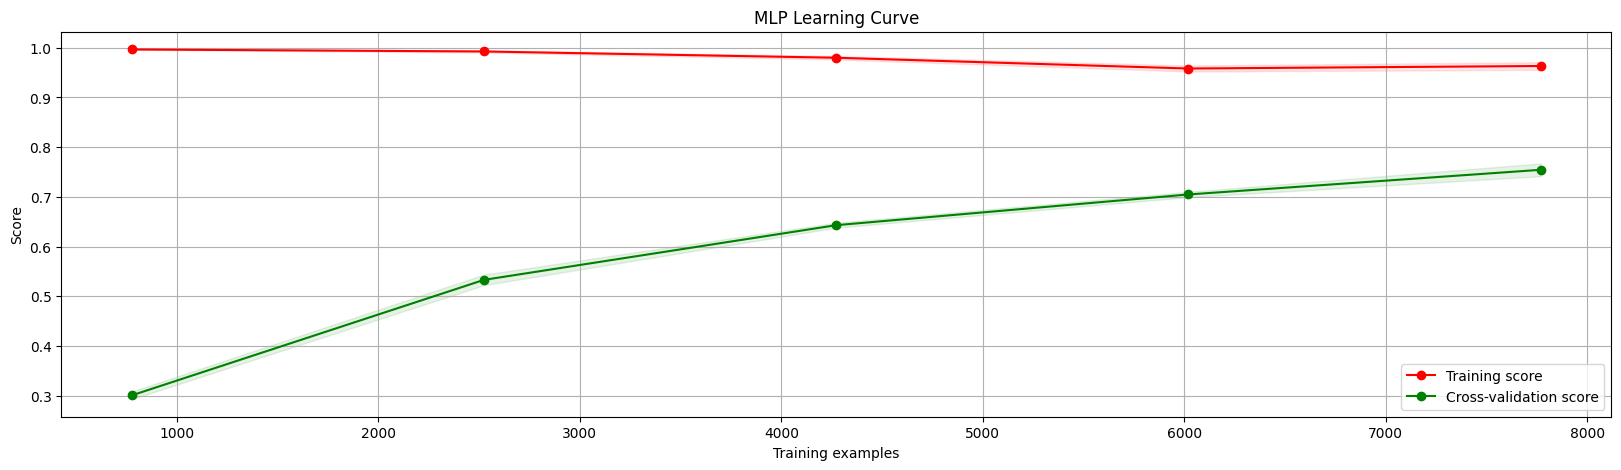


Initial SVM Evaluation:
Cross-validation Accuracy: 0.4520 (+/- 0.0186)


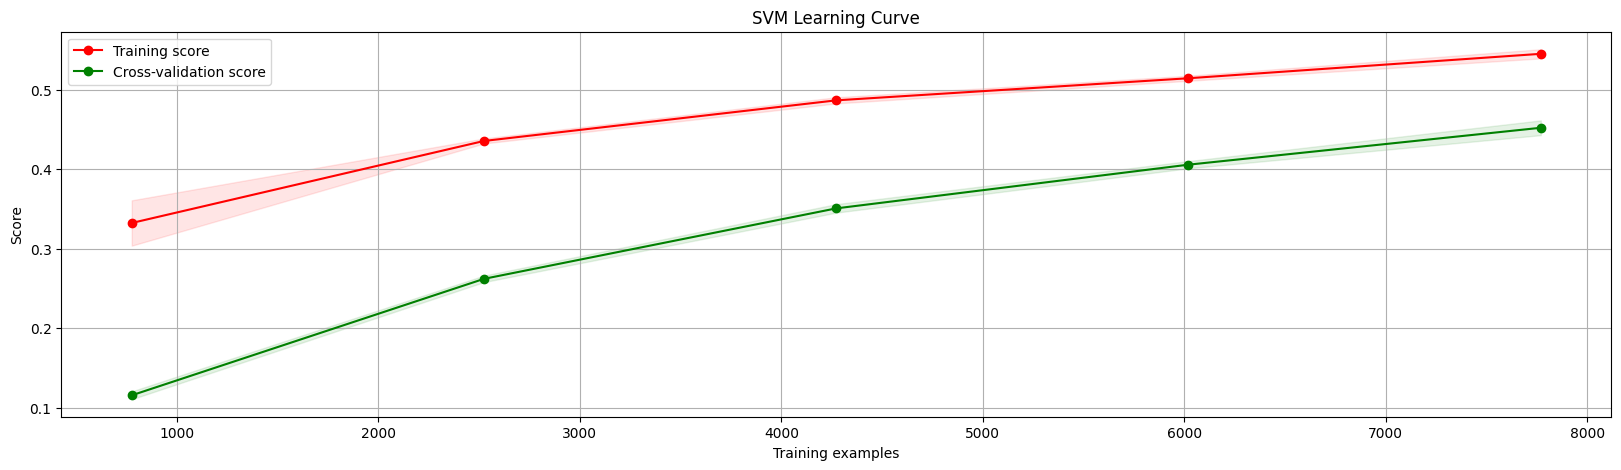


Tuning MLP:
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant'}
Best cross-validation score: 0.7544

Tuning SVM:
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'poly'}
Best cross-validation score: 0.7994


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Best Model: SVM

Final Model Evaluation:
Test Accuracy: 0.8304
Test Log-loss: 1.4535
Test F1-score: 0.8253

Classification Report:
               precision    recall  f1-score   support

     Abundant       0.85      0.85      0.85        13
       Active       0.77      0.71      0.74        14
        Adult       1.00      0.92      0.96        13
        Agile       0.76      0.93      0.84        14
     Alluring       0.53      0.77      0.62        13
      Amiable       0.80      0.86      0.83        14
      Amusing       0.92      0.92      0.92        13
      Aqueous       0.81      1.00      0.90        13
 Aristocratic       0.88      1.00      0.93        14
     Aromatic       1.00      0.93      0.96        14
     Artistic       0.87      1.00      0.93        13
Authoritative       0.63      0.92      0.75        13
       Bitter       0.87      1.00      0.93        13
      Bitterl       1.00      1.00      1.00        13
         Bold       0.69      0.85      0.

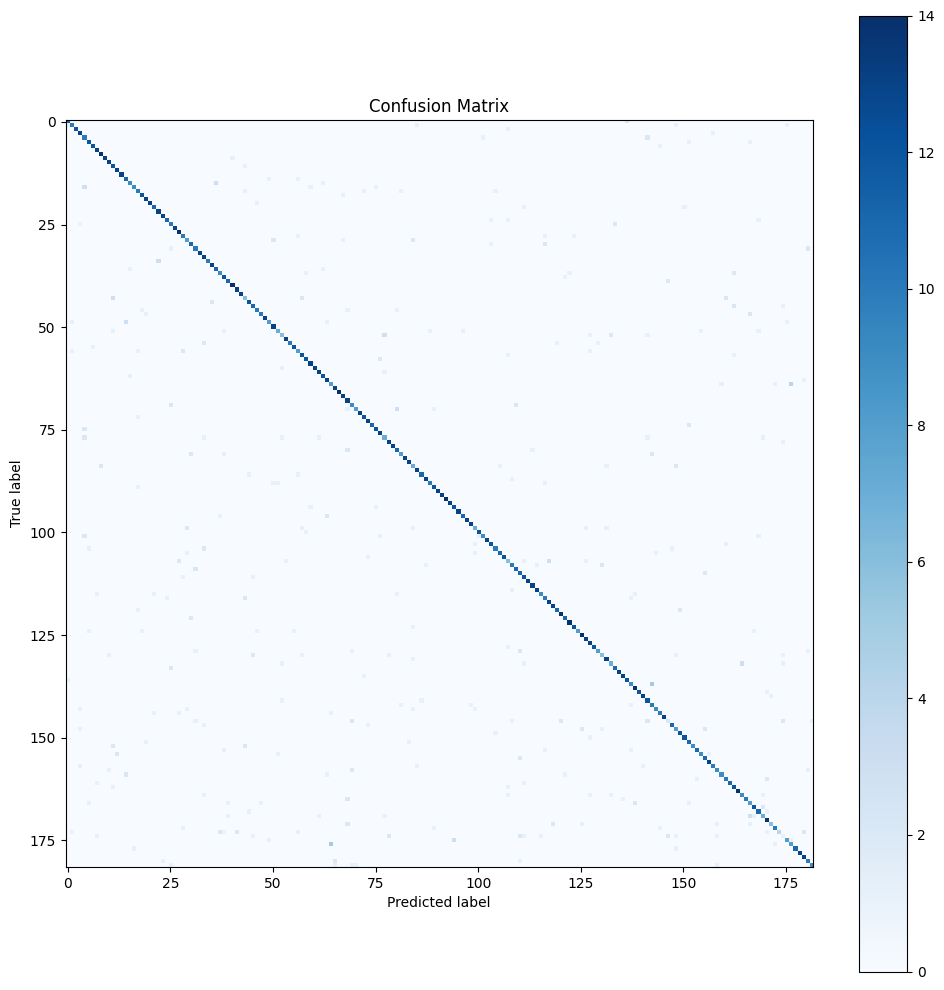

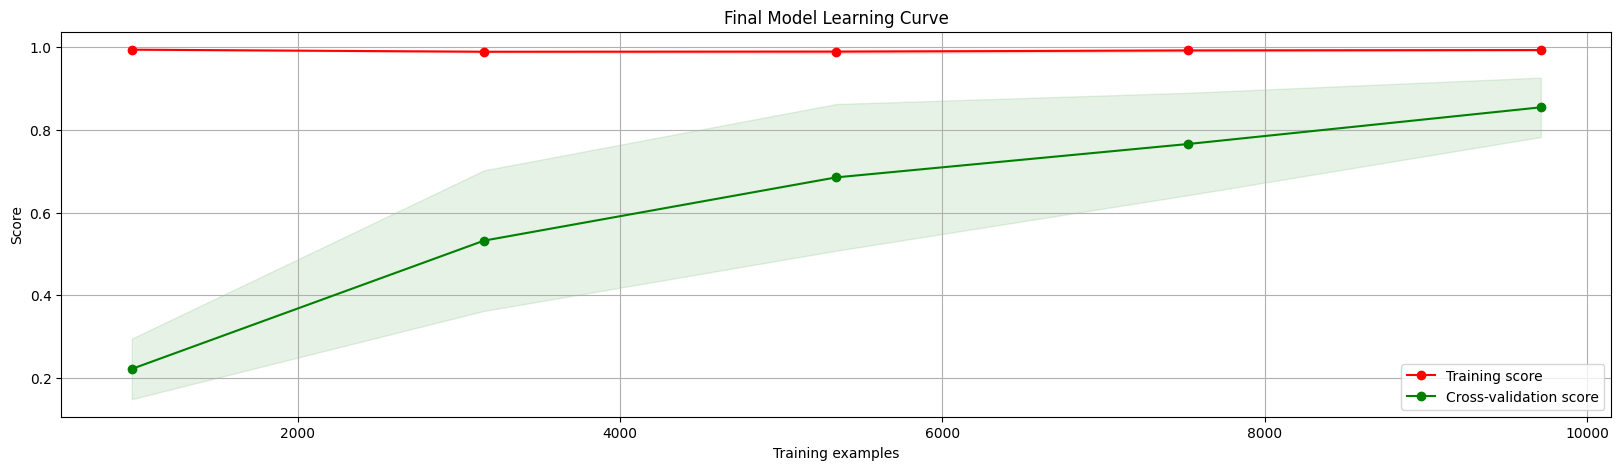


Top 10 Misclassifications:
True: Fresh, Predicted: Neat, Confidence: 0.6087
True: Dreamy, Predicted: Charming, Confidence: 0.6130
True: Healthy, Predicted: Open, Confidence: 0.6354
True: Pleasant, Predicted: Smooth, Confidence: 0.6379
True: Friendly, Predicted: Healthy, Confidence: 0.6734
True: Untamed, Predicted: Delignet, Confidence: 0.6796
True: Active, Predicted: Intense, Confidence: 0.6906
True: Untamed, Predicted: Delignet, Confidence: 0.6992
True: Dazzling, Predicted: Festive, Confidence: 0.7688
True: Festive, Predicted: Bright, Confidence: 0.7974


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss, f1_score, confusion_matrix, classification_report

# 1. Data Preparation
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Helper functions
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
    axes.legend(loc="best")

    return plt

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Test Log-loss: {log_loss(y_test, y_pred_proba):.4f}")
    print(f"Test F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 2. Initial Model Evaluation
models = {
    'MLP': Pipeline([('scaler', StandardScaler()),
                     ('mlp', MLPClassifier(max_iter=1000, random_state=42))]),
    'SVM': Pipeline([('scaler', StandardScaler()),
                     ('svm', SVC(probability=True, random_state=42))])
}

for name, model in models.items():
    print(f"\nInitial {name} Evaluation:")
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    plot_learning_curve(model, f'{name} Learning Curve', X_train, y_train, cv=5)
    plt.show()

# 3 & 4. Address Overfitting/Underfitting and Hyperparameter Tuning
param_grids = {
    'MLP': {
        'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'mlp__alpha': [0.0001, 0.001, 0.01],
        'mlp__learning_rate': ['constant', 'adaptive'],
    },
    'SVM': {
        'svm__C': [0.1, 1, 10],
        'svm__gamma': ['scale', 'auto', 0.1, 1],
        'svm__kernel': ['rbf', 'poly']
    }
}

best_models = {}

for name, model in models.items():
    print(f"\nTuning {name}:")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# 5. Model Selection
best_model_name = max(best_models, key=lambda name: cross_val_score(best_models[name], X_train, y_train, cv=5).mean())
best_model = best_models[best_model_name]
print(f"\nBest Model: {best_model_name}")

# 6 & 7. Final Model Evaluation and Learning Curve Analysis
print("\nFinal Model Evaluation:")
evaluate_model(best_model, X_train, X_test, y_train, y_test)
plot_learning_curve(best_model, 'Final Model Learning Curve', X, y, cv=5)
plt.show()

# 8. Error Analysis
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

def print_top_misclassifications(y_true, y_pred, y_pred_proba, top_n=10):
    misclassified = y_true != y_pred
    misclassified_indices = np.where(misclassified)[0]
    misclassified_proba = y_pred_proba[misclassified_indices].max(axis=1)
    top_misclassified = misclassified_indices[np.argsort(misclassified_proba)[-top_n:]]
    
    print(f"\nTop {top_n} Misclassifications:")
    for idx in top_misclassified:
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        confidence = y_pred_proba[idx].max()
        print(f"True: {true_label}, Predicted: {pred_label}, Confidence: {confidence:.4f}")

print_top_misclassifications(y_test, y_pred, y_pred_proba)

### Some notes from the output

- Cross-validation Accuracy: 0.4520 (+/- 0.0186) : το +/- 0.0186 δείχνει το διάστημα εμπιστοσύνης 95%. Αυτό σημαίνει ότι είμαστε 95% σίγουροι πως η πραγματική ακρίβεια του μοντέλου SVM, σε νέα δεδομένα, θα κυμαίνεται μεταξύ 43.34% και 47.06%.

- Top 10 Mis classifications :  (Κορυφαίες 10 Λανθασμένες Ταξινομήσεις):
    Αυτή η λίστα δείχνει τις περιπτώσεις όπου το μοντέλο προέβλεψε λάθος την κατηγορία στην οποία ανήκει ένα αντικείμενο, παρόλο που ήταν σχετικά σίγουρο για την πρόβλεψή του. Για κάθε περίπτωση, βλέπουμε:

    - True (Πραγματική τιμή): Η πραγματική κατηγορία στην οποία ανήκει το αντικείμενο.
    - Predicted (Προβλεπόμενη τιμή): Η κατηγορία που προέβλεψε το μοντέλο.
    - Confidence (Σιγουριά): Πόσο σίγουρο ήταν το μοντέλο για την πρόβλεψή του (σε κλίμακα από 0 έως 1).

    Πολλά από τα λάθη γίνονται μεταξύ κατηγοριών που έχουν παρόμοια σημασία (π.χ., "Fresh" και "Neat", "Dreamy" και "Charming").
    Το μοντέλο είναι αρκετά σίγουρο για τις προβλέψεις του, ακόμα και όταν αυτές είναι λάθος.
    Κάποια ζευγάρια κατηγοριών εμφανίζονται πολλές φορές (π.χ., "Untamed" προβλέπεται ως "Delignet" δύο φορές), υποδεικνύοντας μια συστηματική σύγχυση μεταξύ τους.
    
    Αυτά τα λάθη αναδεικνύουν τις δυσκολίες αυτού του προβλήματος ταξινόμησης. Πολλές από τις κατηγορίες είναι εννοιολογικά παρόμοιες, γεγονός που εξηγεί γιατί το μοντέλο δυσκολεύεται να τις διακρίνει. Αυτό υποδηλώνει ότι:

### This version introduces a Keras-based MLP model and uses KerasClassifier for compatibility with scikit-learn's GridSearchCV.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, AdamW
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, AdamW
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Load and preprocess the data
data = pd.read_csv('resampled_dataset.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Learning rate scheduler
def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 10))

# Modified create_mlp_model function
def create_mlp_model(hidden_layers=1, neurons=64, activation='relu', optimizer='adam'):
    def build_fn(meta):
        n_features_in_ = meta["n_features_in_"]
        n_classes_ = meta["n_classes_"]
        
        model = Sequential()
        model.add(Dense(neurons, input_shape=(n_features_in_,), activation=activation))
        
        for _ in range(hidden_layers - 1):
            model.add(Dense(neurons, activation=activation))
        
        model.add(Dropout(0.5))
        model.add(Dense(n_classes_, activation='softmax'))
        
        if optimizer == 'adam':
            opt = Adam()
        elif optimizer == 'adamw':
            opt = AdamW()
        else:
            opt = Adam()
        
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model
    return build_fn


def perform_grid_search(model, param_grid, X, y):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X, y)
    return grid_search

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
    )
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.grid()
    
    plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color="r")
    plt.fill_between(train_sizes, np.mean(test_scores, axis=1) - np.std(test_scores, axis=1),
                     np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), alpha=0.1, color="g")
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

# Define parameter grids
mlp_param_grid = {
    'model__hidden_layers': [1, 2, 3],
    'model__neurons': [64, 128, 256],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'adamw']
}

svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto', 0.1, 1],
    'svm__kernel': ['rbf']
}

# Create ensemble
best_mlp = KerasClassifier(model=create_mlp_model(**mlp_grid_search.best_params_), epochs=100, batch_size=32, verbose=0,
                           callbacks=[EarlyStopping(patience=10), LearningRateScheduler(lr_schedule)])
best_svm = svm_grid_search.best_estimator_

ensemble = VotingClassifier(estimators=[('mlp', best_mlp), ('svm', best_svm)], voting='soft')

# Evaluate ensemble using cross-validation
cv_scores = cross_val_score(ensemble, X, y, cv=5, scoring='accuracy')
print(f"Ensemble Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Final evaluation
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
y_pred_proba = ensemble.predict_proba(X_test)

print("\nEnsemble Test Set Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Log-loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

Performing Grid Search for MLP...


ValueError: 
All the 180 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Python312\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Python312\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._ensure_compiled_model()
  File "c:\Python312\Lib\site-packages\scikeras\wrappers.py", line 439, in _ensure_compiled_model
    if not self.model_.compiled:
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'function' object has no attribute 'compiled'
